In [1]:
#Loading Packages
import pandas as pd 
import numpy as np                     # For mathematical calculations 
import seaborn as sns                  # For data visualization 
import matplotlib.pyplot as plt        # For plotting graphs 
%matplotlib inline 
import warnings                        # To ignore any warnings warnings.filterwarnings("ignore")
import itertools
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import classification_report, accuracy_score, auc, f1_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [79]:
data = pd.read_csv('./data/data_scaled_yeo-johnson.csv',sep=',', encoding='utf8')
data.head()

,Unnamed: 0,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,0,-1.301885,-0.875862,-1.892859,0.188898,-0.767026,-1.434002,0.209330,0.356983,0.112478,2.300448,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,1,-1.317747,-0.804208,-2.207409,-0.030821,-0.966776,-1.634289,0.161846,0.551429,0.193087,2.282208,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2,-0.685826,0.081256,-0.605934,0.233680,0.398798,0.673140,0.885431,0.754744,-0.232387,2.246761,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,3,-0.747674,0.214532,0.628511,0.115173,1.192451,0.627067,1.116561,0.754744,-0.569637,2.277460,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,4,-1.304535,-0.966982,-2.207409,-0.356327,-0.796439,-1.632476,0.161846,0.485642,0.166176,2.264196,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [80]:
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
x = data.drop('Cover_Type', axis=1)
features = list(x.columns)
y = data['Cover_Type']

In [76]:
#x = x[["Elevation", "Soil_Type3", "Soil_Type10", "Soil_Type12", "Soil_Type35", "Soil_Type38", "Soil_Type30", "Soil_Type39", "Wilderness_Area1"]]
#features = list(x.columns)

In [81]:
#We will use the train_test_split function from sklearn to divide our train dataset. 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
features = list(x.columns)

In [ ]:
svm_model_multi = OneVsOneClassifier(SVC(kernel='rbf', C=1))

svm_model_multi.fit(x_train, y_train)

y_pred = svm_model_multi.predict(x_test)

print(classification_report(y_test, y_pred))

In [24]:
svm_model_multi.estimator.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [43]:
param_test = {'estimator__C':[1, 10, 100],'estimator__gamma':[1, 0.1], 'estimator__kernel':['linear', 'rbf']}

#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch = GridSearchCV(estimator=svm_model_multi, param_grid=param_test, scoring='f1_micro', verbose=10, cv=5, refit = True)

gsearch.fit(x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] estimator__C=1, estimator__gamma=10, estimator__kernel=linear ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  estimator__C=1, estimator__gamma=10, estimator__kernel=linear, score=0.706, total=   5.3s
[CV] estimator__C=1, estimator__gamma=10, estimator__kernel=linear ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  estimator__C=1, estimator__gamma=10, estimator__kernel=linear, score=0.710, total=   5.4s
[CV] estimator__C=1, estimator__gamma=10, estimator__kernel=linear ...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s


[CV]  estimator__C=1, estimator__gamma=10, estimator__kernel=linear, score=0.708, total=   5.3s
[CV] estimator__C=1, estimator__gamma=10, estimator__kernel=linear ...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.0s remaining:    0.0s


[CV]  estimator__C=1, estimator__gamma=10, estimator__kernel=linear, score=0.697, total=   5.2s
[CV] estimator__C=1, estimator__gamma=10, estimator__kernel=linear ...


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.2s remaining:    0.0s


[CV]  estimator__C=1, estimator__gamma=10, estimator__kernel=linear, score=0.697, total=   5.4s
[CV] estimator__C=1, estimator__gamma=10, estimator__kernel=rbf ......


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.6s remaining:    0.0s


[CV]  estimator__C=1, estimator__gamma=10, estimator__kernel=rbf, score=0.531, total=  48.0s
[CV] estimator__C=1, estimator__gamma=10, estimator__kernel=rbf ......


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV]  estimator__C=1, estimator__gamma=10, estimator__kernel=rbf, score=0.546, total=  48.1s
[CV] estimator__C=1, estimator__gamma=10, estimator__kernel=rbf ......


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.0min remaining:    0.0s


KeyboardInterrupt: ignored

In [40]:
print(gsearch.best_score_)
print(gsearch.best_params_)

0.837612730028404
{'estimator__C': 1, 'estimator__degree': 1, 'estimator__gamma': 1, 'estimator__kernel': 'rbf'}


In [55]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    #y_score = clf.decision_function(X_test)
    if hasattr(clf, 'predict_proba'):
      y_score = clf.predict_proba(X_test)
    else:
      y_score = clf.decision_function(X_test)
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()


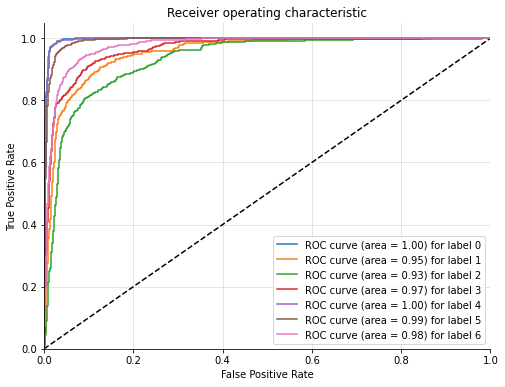

In [32]:
plot_multiclass_roc(gsearch, x_test, y_test, n_classes=7, figsize=(8, 6))

In [58]:
def plot_confusion_matrix(y_test,y_pred):
  matrix = confusion_matrix(y_test,y_pred)

  plt.clf()

  # place labels at the top
  plt.gca().xaxis.tick_top()
  plt.gca().xaxis.set_label_position('top')

  # plot the matrix per se
  plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

  # plot colorbar to the right
  plt.colorbar()

  fmt = 'd'

  # write the number of predictions in each bucket
  thresh = matrix.max() / 2.
  for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):

    # if background is dark, use a white number, and vice-versa
    plt.text(j, i, format(matrix[i, j], fmt),
         horizontalalignment="center",
         color="white" if matrix[i, j] > thresh else "black")

  ##tick_marks = np.arange(len(y))
  ##plt.xticks(tick_marks, y, rotation=45)
  #plt.yticks(tick_marks, y)
  #plt.tight_layout()
  plt.ylabel('True label',size=14)
  plt.xlabel('Predicted label',size=14)
  plt.show()

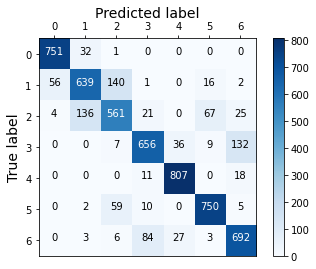

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       784
           1       0.79      0.75      0.77       854
           2       0.72      0.69      0.71       814
           3       0.84      0.78      0.81       840
           4       0.93      0.97      0.95       836
           5       0.89      0.91      0.90       826
           6       0.79      0.85      0.82       815

    accuracy                           0.84      5769
   macro avg       0.84      0.84      0.84      5769
weighted avg       0.84      0.84      0.84      5769



In [36]:
y_pred = gsearch.predict(x_test)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [46]:
#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()   

In [77]:
sk_model = xgb.XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=7,
                    seed=27)

sk_model.fit(x_train, y_train)

train = xgb.DMatrix(x_train, label=y_train)
val = xgb.DMatrix(x_test, label=y_test)
params = sk_model.get_xgb_params()
metrics = ['mlogloss','merror']
params['eval_metric'] = metrics
epochs=300
store = {}
evallist = [(val, 'val'),(train,'train')]
xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
print('-- Model Report --')
print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(x_test), y_test)))
print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(x_test),y_test,average='micro')))



[0]	val-mlogloss:1.74759	val-merror:0.25013	train-mlogloss:1.73073	train-merror:0.181694
[100]	val-mlogloss:0.448958	val-merror:0.175247	train-mlogloss:0.180087	train-merror:0.036859
[200]	val-mlogloss:0.426653	val-merror:0.162507	train-mlogloss:0.082162	train-merror:0.004485
[299]	val-mlogloss:0.429957	val-merror:0.155486	train-mlogloss:0.041634	train-merror:0
-- Model Report --
XGBoost Accuracy: 0.8499739989599584
XGBoost F1-Score (Micro): 0.8499739989599584


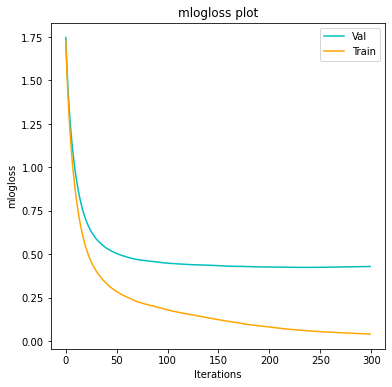

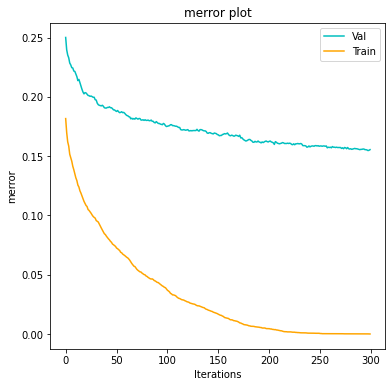

KeyError: ignored

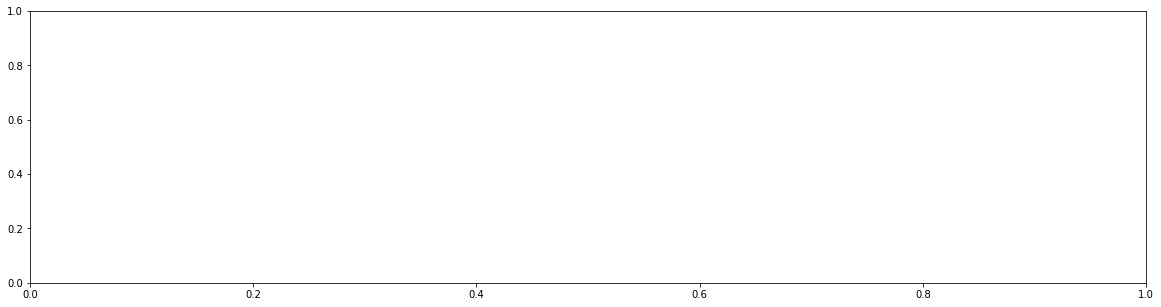

In [78]:
plot_compare(metrics,store,epochs) 

f, ax = plt.subplots(figsize=(20,5))
plot = sns.barplot(x=features, y=sk_model.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

In [48]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

In [49]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,5,2)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch1 = GridSearchCV(estimator = sk_model, param_grid = param_test1, scoring='f1_macro', n_jobs=-1, verbose = 10, cv=5, refit = True)
gsearch1.fit(x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 39.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 61.5min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 66.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=4, num_class=7,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 5, 2)},
             

In [50]:
getTrainScores(gsearch1)

({0: "mean:0.836386595167155params{'max_depth': 3, 'min_child_weight': 1}",
  1: "mean:0.8354116888347687params{'max_depth': 3, 'min_child_weight': 3}",
  2: "mean:0.8563377375030943params{'max_depth': 5, 'min_child_weight': 1}",
  3: "mean:0.8545104901144045params{'max_depth': 5, 'min_child_weight': 3}",
  4: "mean:0.8618779312036106params{'max_depth': 7, 'min_child_weight': 1}",
  5: "mean:0.8588597908051911params{'max_depth': 7, 'min_child_weight': 3}",
  6: "mean:0.8651985002262362params{'max_depth': 9, 'min_child_weight': 1}",
  7: "mean:0.8602249643528875params{'max_depth': 9, 'min_child_weight': 3}"},
 {'best_mean': 0.8651985002262362,
  'best_param': {'max_depth': 9, 'min_child_weight': 1}})

In [48]:
param_test2 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch2 = GridSearchCV(estimator = sk_model, param_grid = param_test2, scoring='f1_macro', n_jobs=-1, verbose = 10, cv=5)
gsearch2.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 23.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 23.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=4, num_class=7,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_

In [49]:
getTrainScores(gsearch2)

({0: "mean:0.8452751695461174params{'reg_alpha': 1e-05}",
  1: "mean:0.8455142484734308params{'reg_alpha': 0.01}",
  2: "mean:0.8440164476916457params{'reg_alpha': 0.1}",
  3: "mean:0.8444039673507318params{'reg_alpha': 1}",
  4: "mean:0.6896559193345043params{'reg_alpha': 100}"},
 {'best_mean': 0.8455142484734308, 'best_param': {'reg_alpha': 0.01}})

In [51]:
sk_model = xgb.XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=9,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=7,
                    seed=27)

sk_model.fit(x_train, y_train)

train = xgb.DMatrix(x_train, label=y_train)
val = xgb.DMatrix(x_test, label=y_test)
params = sk_model.get_xgb_params()
metrics = ['mlogloss','merror']
params['eval_metric'] = metrics
epochs=300
store = {}
evallist = [(val, 'val'),(train,'train')]
xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
print('-- Model Report --')
print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(x_test), y_test)))
print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(x_test),y_test,average='micro')))

[0]	val-mlogloss:1.76147	val-merror:0.24883	train-mlogloss:1.75038	train-merror:0.210102
[100]	val-mlogloss:0.382892	val-merror:0.145346	train-mlogloss:0.15026	train-merror:0.022427
[200]	val-mlogloss:0.356265	val-merror:0.137806	train-mlogloss:0.053455	train-merror:0.000195
[299]	val-mlogloss:0.362646	val-merror:0.136765	train-mlogloss:0.025687	train-merror:0
-- Model Report --
XGBoost Accuracy: 0.8642745709828393
XGBoost F1-Score (Micro): 0.8642745709828393


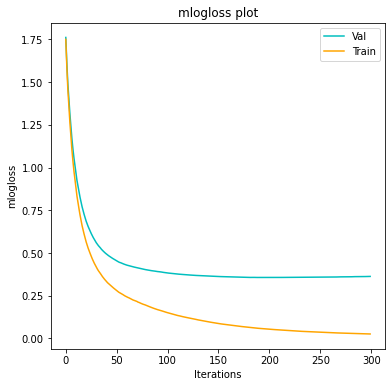

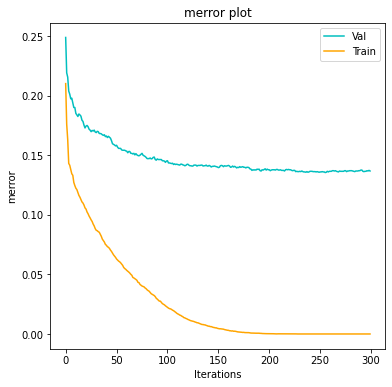

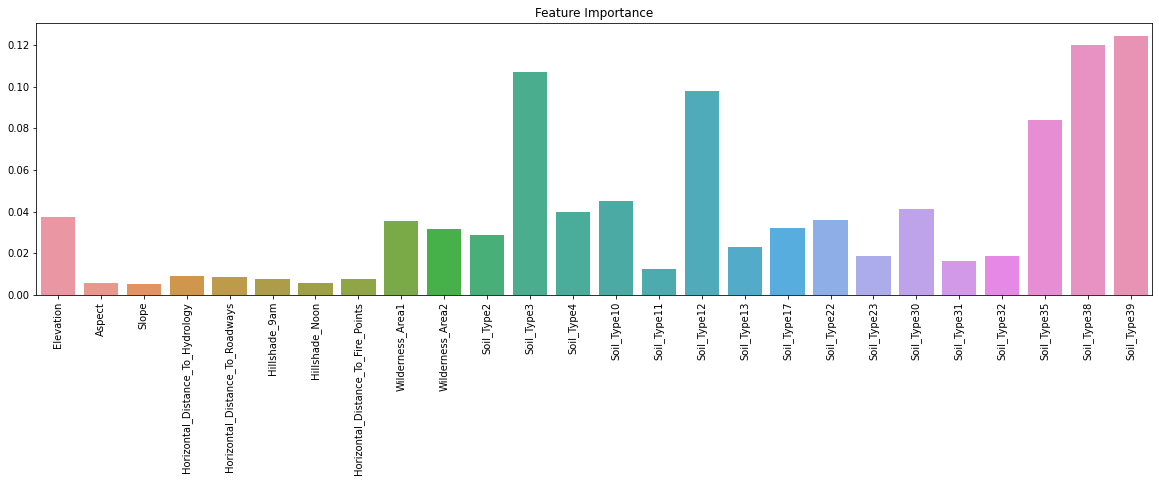

In [52]:
plot_compare(metrics,store,epochs) 

f, ax = plt.subplots(figsize=(20,5))
plot = sns.barplot(x=features, y=sk_model.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

In [53]:
y_pred = sk_model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       599
           1       0.77      0.76      0.76       542
           2       0.76      0.67      0.71       520
           3       0.87      0.83      0.85       553
           4       0.95      0.96      0.96       546
           5       0.89      0.96      0.93       544
           6       0.84      0.88      0.86       542

    accuracy                           0.86      3846
   macro avg       0.86      0.86      0.86      3846
weighted avg       0.86      0.86      0.86      3846



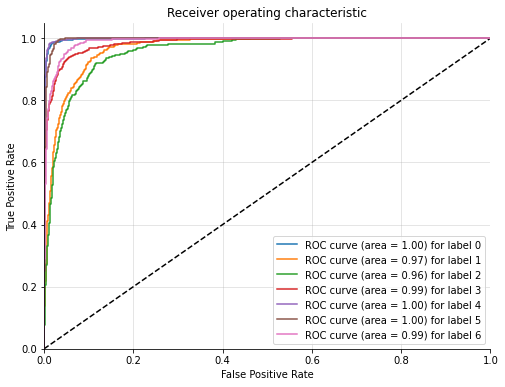

In [56]:
plot_multiclass_roc(sk_model, x_test, y_test, n_classes=7, figsize=(8, 6))

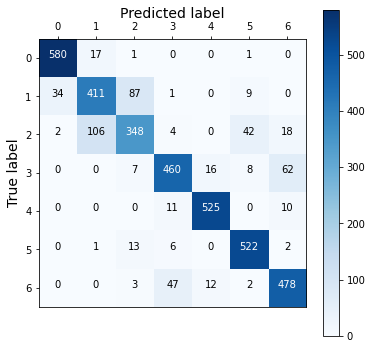

In [59]:
plot_confusion_matrix(y_test, y_pred)

In [60]:
import pickle

pickl = {'model': gsearch}
pickle.dump(pickl, open('model_svm.pkl','wb'))

pickl = {'model': sk_model}
pickle.dump(pickl, open('model_xgb.pkl','wb'))

In [ ]:
file_name = 'model_xgb.pkl'
with open(file_name,'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']